## Segmenting Brain Tumours with UNet Variants

<img src="https://i.imgur.com/Q8oI4M6.png"
     align="right"
     width="300"
     style="padding: 20px;" />

The objective of this notebook is to use different versions of the [UNet](https://arxiv.org/abs/1505.04597) architecture to segment tumours from brain scan images.

We'll begin with the original UNet, then work in some modern computer vision tweaks before building in an attention mechanism. We finish with a model that has 60% of the number of parameters of the original UNet, but with less than half the loss and state of the art performance.

### Loading the Dataset
This dataset stores each input and target pair in a single Python dictionary object, each of which as been saved as a .h5 file, where the image input is saved in the key `image`, and the target segmentation mask is under the key `mask`.

We'll load the paths of our dataset, then each file is stored and formatted.

In [1]:
import torch
import numpy as np
import os
import h5py

# Directory containing .h5 files
path_to_data = '/kaggle/input/mri-brain-scans-segmentation/archive(1)/'  # Changed it accordingly
directory = f'{path_to_data}BraTS2020_training_data/content/data'
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Define device which would be used at the beginning of everything

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = os.path.join(directory, h5_files[25070])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 57195 .h5 files:
Example file names:['volume_337_slice_56.h5', 'volume_293_slice_67.h5', 'volume_149_slice_44.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 20.749972557838987
Array min val: -0.15242355609407895

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 0
Array min val: 0


## About the Dataset
Our dataset consists of images from brain scans, as well as masked labels indicating regions of abnormal tissue. Each image has 4 channels.

#### Image channels:
1) **T1-weighted (T1)**: This sequence produces a high resolution image of the brain's anatomy. It's good for visualising the structure of the brain but not as sensitive to tumour tissue as other sequences.

2) **T1-weighted post contrast (T1c or T1Gd)**: After the injection of a contrast agent (usually gadolinium), T1-weighted images are taken again. The contrast agent enhances areas with a high degree of vascularity and blood-brain barrier breakdown, which is typical in tumour tissue, making this sequence particularly useful for highlighting malignant tumours.

3) **T2-weighted (T2)**: T2 images provide excellent contrast of the brain's fluid spaces and are sensitive to edema (swelling), which often surrounds tumours. It helps in visualizing both the tumour and changes in nearby tissue.

4) **Fluid Attenuated Inversion Recovery (FLAIR)**: This sequence suppresses the fluid signal, making it easier to see peritumoral edema (swelling around the tumour) and differentiate it from the cerebrospinal fluid. It's particularly useful for identifying lesions near or within the ventricles.

Regarding the masks, they represent segmentations, containing areas of interest within the brain scans, specifically focusing on abnormal tissue related to brain tumours. We will use these masks for training models in segmenting brain tumours from normal brain tissue. Each mask has 3 channels.

#### Mask channels
1) **Necrotic and Non-Enhancing Tumour Core (NCR/NET)**: This masks out the necrotic (dead) part of the tumour, which doesn't enhance with contrast agent, and the non-enhancing tumour core.

2) **Edema (ED)**: This channel masks out the edema, the swelling or accumulation of fluid around the tumour.

3) **Enhancing Tumour (ET)**: This masks out the enhancing tumour, which is the region of the tumour that shows uptake of contrast material and is often considered the most aggressive part of the tumour.

### Viewing Sample Images
We'll use matplotlib imshow to view some example brain scans, and see the tumour locations.

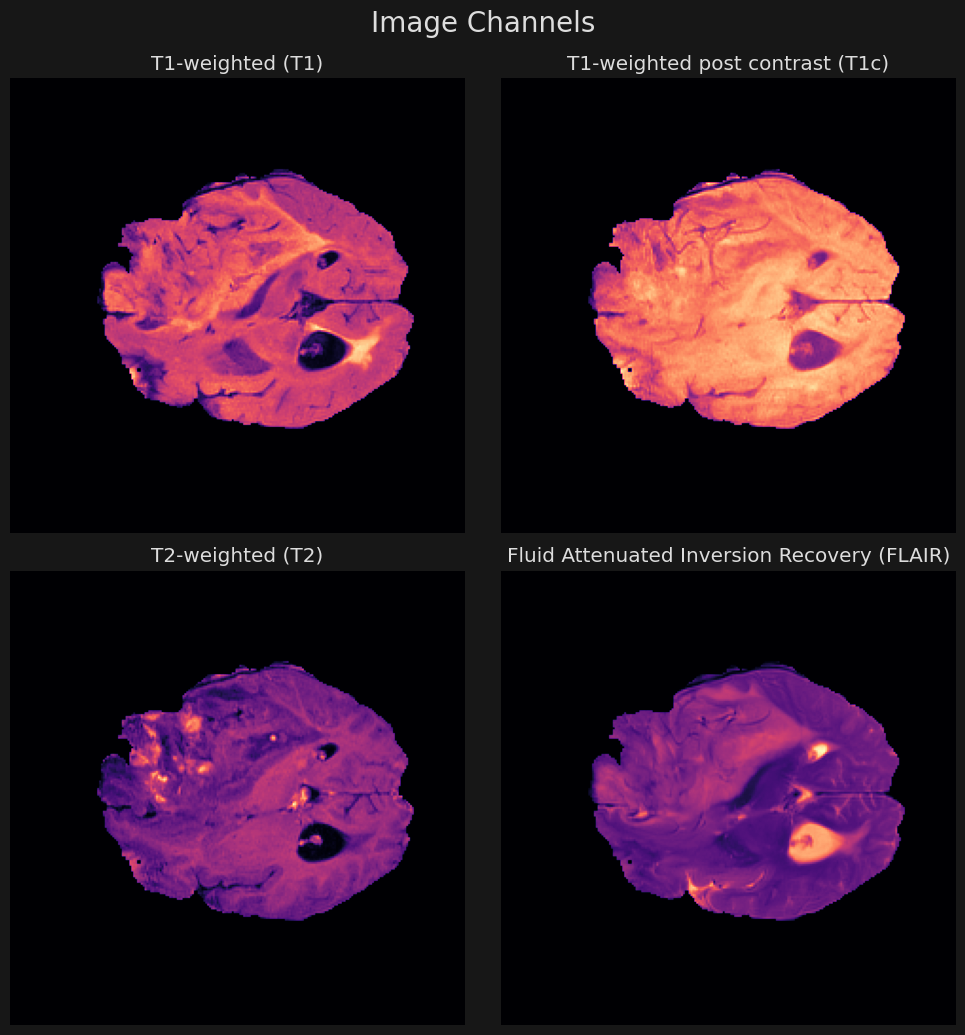

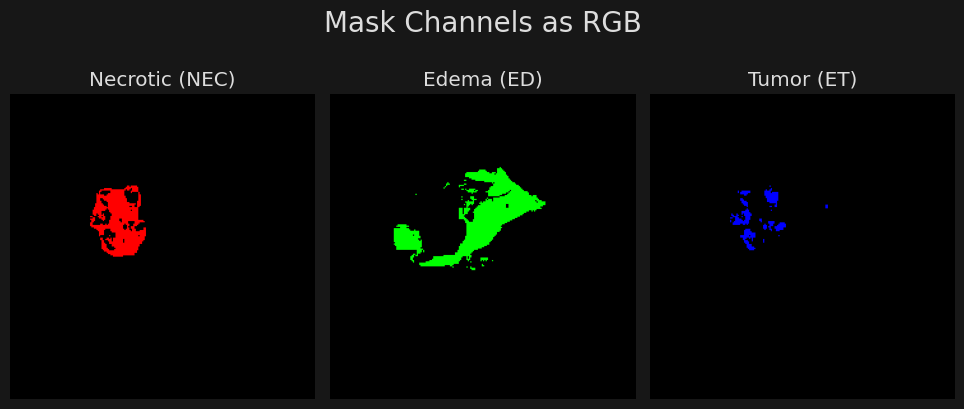

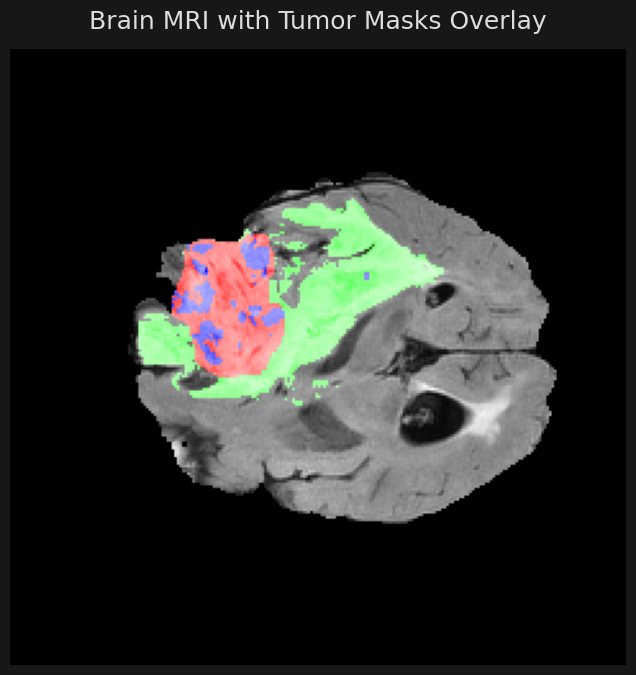

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumor (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumor Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()


# Sample image to view
sample_file_path = os.path.join(directory, h5_files[1])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

### Creating a Dataset and DataLoader
Our dataset is fairly large at ~8GB, so during training we will use dataloaders to load batches of image + target pairs. Since these images are formatted unconventionally, we'll need to build a custom Dataset object and DataLoader.

Images are stored using the `float64` data type with pixel intensities ranging from ~-0.5 to ~230 and `height`, `width`, `channels` format. The masks use the `uint8` data type and pixels have values of either 0 or 1.

Our dataloader will need to load an image, reshape it so it's formatted `channels`, `height`, `width` for use in PyTorch, adjust pixel intensities so the minimum value is 0 on every image, then scale each channel so the max is 1, then convert to a `torch.float32` tensor.

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]

            # Reshape: (H, W, C) -> (C, H, W)
            image = image.transpose(2, 0, 1)
            mask = mask.transpose(2, 0, 1)

            # Adjusting pixel values for each channel in the image so they are between 0 and 255
            for i in range(image.shape[0]):    # Iterate over channels
                min_value = np.min(image[i])
                image[i] = (image[i] - min_value)/(np.max(image[i]) - min_value + 1e-8) * 255 # Addition to avoid division by zero

            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

# Build .h5 file paths from directory containing .h5 files
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.9 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    assert images.shape == torch.Size([5, 4, 240, 240])
    assert masks.shape == torch.Size([5, 3, 240, 240])
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


## The UNet Architecture

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png"
     align="right"
     width="500"
     style="padding: 20px;" />
     
[UNet](https://arxiv.org/abs/1505.04597) is a deep learning neural network architecture originally designed for image segmentation tasks, but has since found use in GANs and latent diffusion models. Similar to autoencoders, the UNet structures include an encoder for compressing the input into a lower dimensional representation and a decoder for reconstructing the output from this compressed form. However, UNet distinguishes itself from autoencoders with several features:

- **Bottleneck**: At the centre of UNet is the bottleneck layer, situated between the encoder and decoder. This component captures the most abstract representation of the input.

- **Symmetrical Design**: The encoder and decoder parts of UNet are mirror images of each other. This symmetry facilitates the implementation of skip connections, which directly connect layers of the encoder to their corresponding layers in the decoder.

- **Skip Connections**: Unlike conventional autoencoders, UNet incorporates skip connections that can bypass the bottleneck, directly connecting the encoder to the decoder. These connections transfer contextual information from the spatially rich encoder, to the more feature heavy decoder, aiding in the precise localisation necessary for detailed segmentation.

In this project we're going to start off with the original UNet architecture, then work on building in some staple CV tweaks like separable convolution layers, batch norm, fewer activation functions, additive skip connections, larger kernels, then finally include the attention mechanism from [Attention UNet](https://arxiv.org/abs/1804.03999).

### 2 points

In [4]:
from torch import nn
from torchvision.transforms import CenterCrop

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            activation
        )

    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()

        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, n_filters)
        self.enc_block_2 = EncoderBlock(n_filters, 2*n_filters)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters)

        # Bottleneck
        self.bottleneck  = EncoderBlock(8*n_filters, 8*n_filters)

        # Decoder
        self.dec_block_4 = DecoderBlock((8+8)*n_filters, 8*n_filters)
        self.dec_block_3 = DecoderBlock((8+4)*n_filters, 4*n_filters)
        self.dec_block_2 = DecoderBlock((4+2)*n_filters, 2*n_filters)
        self.dec_block_1 = DecoderBlock((2+1)*n_filters, n_filters)

        # Output projection
        self.output      = nn.Conv2d(1*n_filters, out_channels, kernel_size=(1,1), stride=1, padding=0)


    def forward(self, x):
        e1 = self.enc_block_1(x) # Highest dec block 32
        x  = self.downsample(e1)
        e2 = self.enc_block_2(x) # Second 64
        x  = self.downsample(e2)
        e3 = self.enc_block_3(x) # Third 128
        x  = self.downsample(e3)
        e4 = self.enc_block_4(x) # Above bottleneck 256
        x  = self.downsample(e4)

        # Bottleneck
        x  = self.bottleneck(x) # Should be 512

        # Decoder
        x  = self.upsample(x)
        e4 = CenterCrop(x.shape[2:])(e4)
        # print(e4.shape)
        # print(x.shape)
        d4 = self.dec_block_4(torch.cat([e4, x], dim=1))
        x  = self.upsample(d4)
        e3 = CenterCrop(x.shape[2:])(e3)
        d3 = self.dec_block_3(torch.cat([e3, x], dim=1))
        x  = self.upsample(d3)
        e2 = CenterCrop(x.shape[2:])(e2)
        d2 = self.dec_block_2(torch.cat([e2, x], dim=1))
        x  = self.upsample(d2)
        e1 = CenterCrop(x.shape[2:])(e1)
        d1 = self.dec_block_1(torch.cat([e1, x], dim=1))
        x  = self.output(d1)

        return x

# Function to count number of parameters in a model for comparisons later
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

# Function that saves a model to specified path
def save_model(model, path='model_weights.pth'):
    torch.save(model.state_dict(), path)

### Training Loop
The code in the cell below defines and executes the training loop for our UNet models.

The training process involves:
- Setting up the model and training configuration.
- Initialising the model and moving it to the chosen device.
- Adam optimizer for parameter updates and binary cross-entropy loss as the loss function.
- We then iterate through each epoch, we can optionally dynamically adjust the learning rate.

For each epoch, we conduct both training and validation steps:
- In the training step, we feed batches of data to the model, computes the loss, and updates the model parameters.
- In the validation step, we evaluate the model on a separate dataset to monitor performance without updating model parameters.
- We track and print out the average training and validation losses for each epoch, providing insights into the model's learning progress.

Finally, the function returns lists of training and validation losses for further analysis or plotting.

### 2 points

I'll add a [library](https://smp.readthedocs.io/en/latest/losses.html) with additional losses for segmentation task. I know, it's mostly not that hard to recreate them from scratch, but I'm too lazy and just did it in DLS segmentation hw.

In [5]:
!pip install -q -U git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp 

In [6]:
import torch.nn.functional as F

def boundary_loss(pred, target, epsilon=1e-7): # Doesn't work at all
    """
    Boundary loss implementation.
    
    Params
    -------
    pred: torch.Tensor.
    Predicted segmentation mask.
    
    target: torch.Tensor.
    Target segmentation mask.
    
    epsilon: float. 
    Smoothing to avoid division by zero
    
    Returns
    -------
    boundary_loss: torch.Tensor.
    Boundary loss value.
    """
    
    assert pred.shape == target.shape, \
        f"Shapes of pred and target do not match: {pred.shape} vs {target.shape}" # Not to fuck up again
    
    # Compute BCEWithLogitsloss
    bce_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
    
    # Compute weight map based on distance to boundary
    dist_map = F.conv2d(target, torch.ones(1, 3, 3, 3, device=target.device), padding=1)
    
    boundary_loss = torch.mean(bce_loss * (1 - torch.clamp(dist_map, 0, 1)))
    
    return boundary_loss

In [7]:
def train_model(model, train_dataloader, val_dataloader, 
                learning_rate, n_epochs, lr_decay_factor, verbose=True,
                loss_fn = nn.BCEWithLogitsLoss(),
                batches_per_epoch = 500,
                device='cuda' if torch.cuda.is_available() else 'cpu'):

#     batches_per_epoch = 500 # You can reduce the amount of computing with that

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     loss_fn = smp.losses.TverskyLoss(mode="multilabel", from_logits=True)

    train_epoch_losses = []
    val_epoch_losses = []

    print("Training...")
    current_lr = learning_rate
    for epoch in range(1, n_epochs + 1):

        # Decay learning rate.
        current_lr *= lr_decay_factor if epoch % 2 == 0 else 1

        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose: print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            train_inputs =  train_inputs.to(device)
            train_targets = train_targets.to(device)
            train_preds =  model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            if train_batch_idx >= batches_per_epoch:   # if you want lesser batches amount per epoch
                if verbose: print()
                break
        train_epoch_losses.append(train_epoch_loss/batches_per_epoch)

        # Val step
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(val_dataloader, start=1):
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)
                val_preds = model(val_inputs)
                val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()

            val_epoch_losses.append(val_epoch_loss/batches_per_epoch)

            if verbose: print(f"Epoch: {epoch}, Train loss: {train_epoch_losses[-1]:.6f}, Val loss: {val_epoch_losses[-1]:.6f}, lr {current_lr:.6f}\n")

    print("Training complete.")
    return train_epoch_losses, val_epoch_losses

In [ ]:
# Create UNet model and count params
model = UNet()
count_parameters(model)   # I had 5,496,451 params

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, learning_rate=1e-3, lr_decay_factor=0.5, n_epochs=2, verbose=True,
                                                   batches_per_epoch=len(train_dataloader))

In [ ]:
save_model(model, path='UNet_15_epochs.pth')

### Learning Curves
Here we visualise the training and validation loss over each epoch, helping assess the model's learning progress and identify overfitting.

In [ ]:
# model = UNet()
# model.load_state_dict(torch.load("/kaggle/input/unet20/pytorch/unet/2/UNet_25_epochs.pth"))
# model.to(device)

In [8]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses, plot_limits):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(plot_limits)

    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

In [ ]:
plot_learning_curves(train_epoch_losses, val_epoch_losses, (0,1))

### Viewing a Sample Prediction
This code demonstrates the model's performance on a test sample by displaying the input brain MRI images, the model's predicted mask, and the actual mask (ground truth).

In [9]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')

In [ ]:
# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)

In [10]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    return iou

In [11]:
def score_model(model, metric, data, num_classes):
    with torch.no_grad():
        model.eval()
        class_scores, class_counts = np.zeros(num_classes), np.zeros(num_classes)
        for X_batch, Y_batch in data:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            logits = model(X_batch)
            Y_pred = torch.sigmoid(logits)

            for class_idx in range(num_classes):
                class_Y_pred = Y_pred[:, class_idx, :, :]
                class_Y_batch = Y_batch[:, class_idx, :, :]
                class_iou = metric(class_Y_pred, class_Y_batch).mean().item()
                class_scores[class_idx] += class_iou
                class_counts[class_idx] += 1

        # Mean scores by classes (and color channels at the same time)
        class_avg_scores = [score / count if count > 0 else 0 for score, count in zip(class_scores, class_counts)]
    print(f'IoU for Necrosis: {round(class_avg_scores[0], 3)}')
    print(f'IoU for Edema: {round(class_avg_scores[1], 3)}')
    print(f'IoU for Tumor: {round(class_avg_scores[2], 3)}')
    print(f'Average IoU score: {round(sum(class_avg_scores)/num_classes, 3)}')

# score_model(model, iou_pytorch, DataLoader(val_dataset, batch_size=8, shuffle=False), 3)


## Upgraded UNet
Our current UNet model is smaller than the model used in [UNet](https://arxiv.org/abs/1505.04597), but our model already has a fairly large 5.5 million parameters. Instead of directly increasing the size of our model, we'll work in some more modern computer vision tweaks to it that should improve performance.

#### Separable convolution layers
Popularised by Chollet in [Xception](https://arxiv.org/abs/1610.02357), we're going to use separable convolution layers rather than conventional convolution layers.

#### Batch normalisation
Batch norm has become a staple inclusion in most convnet architectures.

#### Larger kernel sizes
[ConvNeXt](https://arxiv.org/abs/2201.03545) found that using larger kernel sizes of (7x7) outperformed 3x3 kernels in their experiments. We'll adopt this change.

#### Inverse bottlenecks
From [MobileNetV2](https://arxiv.org/abs/1801.04381), we're going to use inverse bottlenecks after our depthwise convolution, to improve the parameter efficiency in our model.

#### Additive skip connections
Rather than using a concat skip connection, we'll use an additive one. (torch.add) This change reduces the number of parameters as well and should give the model a clearer residual signal.

#### Learning rate decay
A standard inclusion to help more powerful models refine their predictions.

### 5 points

In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.GELU()):
        super().__init__()
        expansion_ratio = 4   # use it to scale number of channels

        self.encoder_block = nn.Sequential(
            # ConvNeXt style blocks
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels), # convnext-like
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*expansion_ratio, kernel_size=(1,1), stride=1),  # separable 1x1
            activation,
            nn.Conv2d(in_channels=in_channels*expansion_ratio, out_channels=out_channels, kernel_size=(1,1), stride=1),

            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels*expansion_ratio, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(in_channels=out_channels*expansion_ratio, out_channels=out_channels, kernel_size=(1,1), stride=1),
        )
    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.GELU()):
        super().__init__()
        expansion_ratio = 4

        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels), # convnext-like
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*expansion_ratio, kernel_size=(1,1), stride=1),  # separable 1x1
            activation,
            nn.Conv2d(in_channels=in_channels*expansion_ratio, out_channels=out_channels, kernel_size=(1,1), stride=1),

            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels*expansion_ratio, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(in_channels=out_channels*expansion_ratio, out_channels=out_channels, kernel_size=(1,1), stride=1),
        )
    def forward(self, x):
        return self.decoder_block(x)


class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.GELU() # According to ConvNeXt article

        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, n_filters)
        self.enc_block_2 = EncoderBlock(n_filters, 2*n_filters)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(8*n_filters, 8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(4*8*n_filters, 8*n_filters, kernel_size=(1,1), stride=1),

            nn.Conv2d(8*n_filters, 8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(4*8*n_filters, 8*n_filters, kernel_size=(1,1), stride=1),
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(8*n_filters, 4*n_filters)
        self.dec_block_3 = DecoderBlock(4*n_filters, 2*n_filters)
        self.dec_block_2 = DecoderBlock(2*n_filters, n_filters)
        self.dec_block_1 = DecoderBlock(n_filters, n_filters)

        # Output projection
        self.output = nn.Conv2d(n_filters, out_channels, kernel_size=(1,1), stride=1, padding=0)

    def forward(self, x):
        e1 = self.enc_block_1(x)
        x  = self.downsample(e1)
        e2 = self.enc_block_2(x)
        x  = self.downsample(e2)
        e3 = self.enc_block_3(x)
        x  = self.downsample(e3)
        e4 = self.enc_block_4(x)
        x  = self.downsample(e4)

        # Bottleneck
        x  = self.bottleneck(x)

        # Decoder
        x  = self.upsample(x)
        e4 = CenterCrop(x.shape[2:])(e4)
        d4 = self.dec_block_4(torch.add(e4, x))
        x  = self.upsample(d4)
        e3 = CenterCrop(x.shape[2:])(e3)
        # print(e3.shape)
        # print(x.shape)
        d3 = self.dec_block_3(torch.add(e3, x))
        x  = self.upsample(d3)
        e2 = CenterCrop(x.shape[2:])(e2)
        d2 = self.dec_block_2(torch.add(e2, x))
        x  = self.upsample(d2)
        e1 = CenterCrop(x.shape[2:])(e1)
        d1 = self.dec_block_1(torch.add(e1, x))
        x  = self.output(d1)

        return x

### Training Loop
Identical to the previous one, only with learning rate decay.

In [12]:
import gc
def all_clean(model=None, train_dataloader=None, val_dataloader=None):
    if model is not None:
        del model
    if train_dataloader is not None:
        del train_dataloader
    if val_dataloader is not None:
        del val_dataloader
    gc.collect()
    torch.cuda.empty_cache()
    print("All clean")

In [ ]:
all_clean(model, train_dataloader, val_dataloader)

In [ ]:
# Train config
# Create UNet model and count params
model = UNet2()
count_parameters(model)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True) # Impossible to make a bigger batchsize 
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False) # That's 12.8 Gb of memory

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, 
                                                   learning_rate=1e-3, lr_decay_factor=0.1, n_epochs=2, verbose=True,
                                                   loss_fn=smp.losses.TverskyLoss(mode="binary", from_logits=True),
                                                   batches_per_epoch=len(train_dataloader))

In [ ]:
# model = UNet2()
# model.load_state_dict(torch.load("/kaggle/input/unet20/pytorch/unet/2/UNet2_25_epochs.pth"))
# model.to(device)

In [ ]:
# Plot learning curves
plot_learning_curves(train_epoch_losses, val_epoch_losses, (0, 0.8))
model.to(device)
test_input, test_target = next(test_input_iterator)
# Performance on test image
display_test_sample(model, test_input, test_target, device="cuda")

In [ ]:
# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)

In [ ]:
save_model(model, path='UNet2_12_epochs.pth')

In [ ]:
score_model(model, iou_pytorch, DataLoader(val_dataset, batch_size=8, shuffle=False), 3)

# BONUS PART, NO GRADES

## Attention UNet
[Attention UNet](https://arxiv.org/abs/1804.03999) is a modified version of the UNet architecture that incorporates an attention mechanism into the basic UNet.

<img src="https://i.imgur.com/nI10XH4.png"
     align="center"
     width="700"
     style="padding: 20px;" />

Since the architecture presented in the original [Attention UNet](https://arxiv.org/abs/1804.03999) paper includes many of the dated UNet elements, we're going to build it into our modernised UNet.

The attention mechanism will be implemented over the skip connection, allowing our model to be able to allocate more resources to relevant regions, and 'tune out' the less important parts. The model will learn what to pay attention to during training.

<img src="https://i.imgur.com/bZrJrzT.png"
     align="center"
     width="700"
     style="padding: 20px;" />
     
To explain attention in the context of our image segmentation UNet:

The encoder has good spatial representation but worse feature representation. The decoder has strong feature representations, but may have lost spatial representations as the input moves deeper into the network.

The attention process begins with the *query* (marked with $g$ for *gate* in the diagram), which is derived from the decoder's feature maps. These feature maps are expected to contain a rich representation of the target structure due to the progressive decoding process.

The *key* is generated from the encoder's feature maps (marked $x$ in the diagram), which capture the input image's contextual information. The goal is to identify regions in the encoder's features that are relevant to the query from the decoder.

The *query* and the *key* interact to produce the attention map. This map acts as a filter, highlighting areas to focus on. The attention mechanism computes this by aligning the query with the key, resulting in weights that signify the importance of each feature in the encoder's output.

The *value*, which is also derived from the encoder's feature maps, represents the content that we want to enhance or suppress. The attention map is applied to the *value* through element-wise multiplication, which scales the features accordingly. Features that are deemed relevant by the attention map are emphasized, while others are diminished.

This produces a weighted feature representation where the focus is directed toward the most informative parts of the input, thereby refining the information flow in the network and improving the quality of the segmentation output.

The attention mechanism effectively guides the model to pay more attention to specific areas of the feature maps, ensuring that the final output is more precise and relevant to the segmentation task.

### Building an Attention UNet Model
We'll build the attention mechanism into our custom-build UNet.

There are a few minor differences in how attention is implemented in our model, as we are adding the attended encoder features to the opposite decoder block's feature maps, rather than concatenating them. This approach should just perform better as well as reduce model parameters.

In [15]:
class EncoderBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        expansion_ratio = 4
        
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels*expansion_ratio, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels*expansion_ratio),
            activation,
            nn.Conv2d(in_channels*expansion_ratio, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
            )
        self.downsample = nn.MaxPool2d((2,2), stride=2)
        
    def forward(self, x):
        x = self.encoder_block(x)
        return x, self.downsample(x) 
    
class AttentionResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
 
        self.Wg = nn.Sequential(
            nn.Conv2d(in_channels[0], out_channels, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_channels)
        )
        self.Ws = nn.Sequential(
            nn.Conv2d(in_channels[1], out_channels, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_channels)
        )
        self.output = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0),
            nn.Sigmoid()
        )
        self.activation = activation
 
    def forward(self, g, s):
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        out = self.activation(Wg + Ws)
        return self.output(out)
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        expansion_ratio = 4
 
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)
        self.attn = AttentionResBlock(in_channels, out_channels)
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels[0]+out_channels, out_channels*expansion_ratio, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels*expansion_ratio),
            activation,
            nn.Conv2d(out_channels*expansion_ratio, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
           )
 
    def forward(self, x, s):
        x = self.upsample(x)
        s = self.attn(x, s)
        x = torch.cat([x, s], axis=1)
        x = self.decoder_block(x)
        return x
    
    
class AttentionUNet(nn.Module):
    def __init__(self):
        super().__init__()
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()
        
        # Encoder blocks
        self.enc_block_1 = EncoderBlock(in_channels, n_filters)
        self.enc_block_2 = EncoderBlock(n_filters, 2*n_filters)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters)
         
        # Bottlenecks
        self.bottleneck  = EncoderBlock(4*n_filters, 8*n_filters)
 
        # Decoders
        self.dec_block_1 = DecoderBlock([8*n_filters, 4*n_filters], 4*n_filters)
        self.dec_block_2 = DecoderBlock([4*n_filters, 2*n_filters], 2*n_filters)
        self.dec_block_3 = DecoderBlock([2*n_filters, n_filters], n_filters)
 
        # Output projection
        self.output = nn.Conv2d(n_filters, out_channels, kernel_size=1, padding=0)
 
    def forward(self, x):
        # Encoder
        e1, x = self.enc_block_1(x)
        e2, x = self.enc_block_2(x)
        e3, x = self.enc_block_3(x)
         
        # Bottleneck
        b, _ = self.bottleneck(x)
        
        # Decoder
        d3 = self.dec_block_1(b, e3)
        d2 = self.dec_block_2(d3, e2)
        d1 = self.dec_block_3(d2, e1)
 
        return self.output(d1)

### Training Loop
In this training loop we increase the number of epochs to 25 and slightly increase the learning rate decay constant to accommodate for this greater number of epochs.

In [36]:
all_clean()

All clean


In [37]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Impossible to make a bigger batchsize 
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False) # That's 12.8 Gb of memory

In [38]:
# Create UNet model and count params
model = AttentionUNet()
count_parameters(model)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, 
                                                   learning_rate=1e-3, lr_decay_factor=0.1, n_epochs=10, verbose=True,
                                                   loss_fn=smp.losses.TverskyLoss(mode="binary", from_logits=True),
                                                   batches_per_epoch=400)


# Save weights
save_model(model, 'attention-unet-weights.pth')

Total Parameters: 5,519,411

Training...
Train batch: 400/400, Avg batch loss: 0.757031
Epoch: 1, Train loss: 0.758601, Val loss: 0.255913, lr 0.001000

Train batch: 400/400, Avg batch loss: 0.436968
Epoch: 2, Train loss: 0.438149, Val loss: 0.175493, lr 0.000100

Train batch: 400/400, Avg batch loss: 0.376669
Epoch: 3, Train loss: 0.377494, Val loss: 0.167171, lr 0.000100

Train batch: 400/400, Avg batch loss: 0.357515
Epoch: 4, Train loss: 0.358402, Val loss: 0.155379, lr 0.000010

Train batch: 400/400, Avg batch loss: 0.351011
Epoch: 5, Train loss: 0.351943, Val loss: 0.152663, lr 0.000010

Train batch: 400/400, Avg batch loss: 0.347593
Epoch: 6, Train loss: 0.348309, Val loss: 0.152530, lr 0.000001

Train batch: 400/400, Avg batch loss: 0.344664
Epoch: 7, Train loss: 0.345567, Val loss: 0.153038, lr 0.000001

Train batch: 400/400, Avg batch loss: 0.345026
Epoch: 8, Train loss: 0.346165, Val loss: 0.152849, lr 0.000000

Train batch: 400/400, Avg batch loss: 0.348021
Epoch: 9, Train 

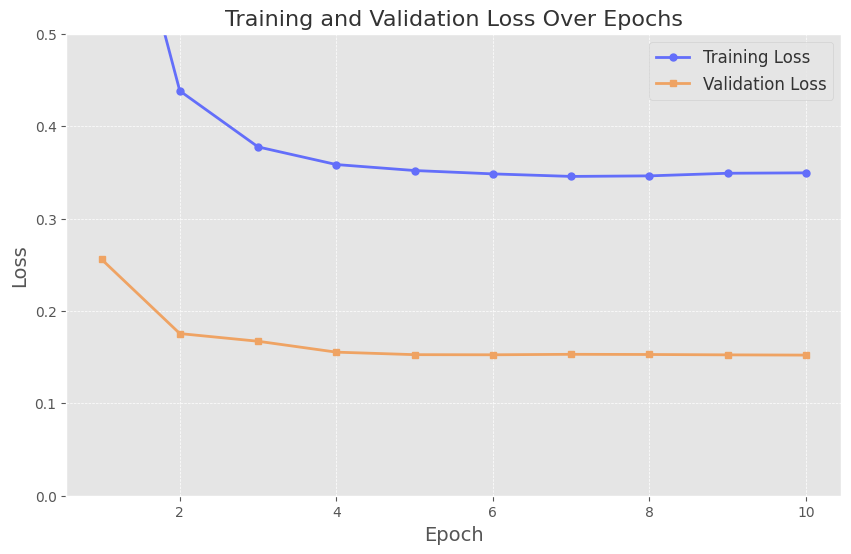

In [39]:
# Plot learning curves
plot_learning_curves(train_epoch_losses, val_epoch_losses, (0, 0.5))

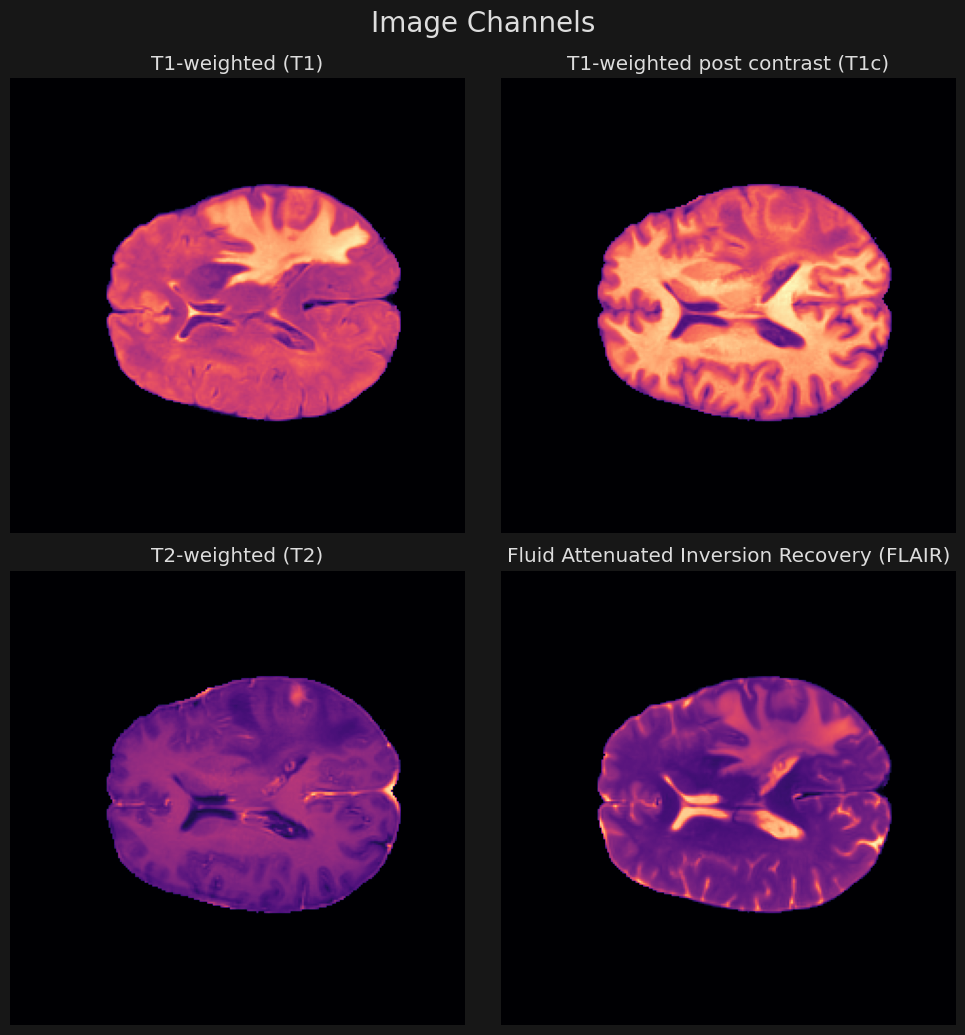

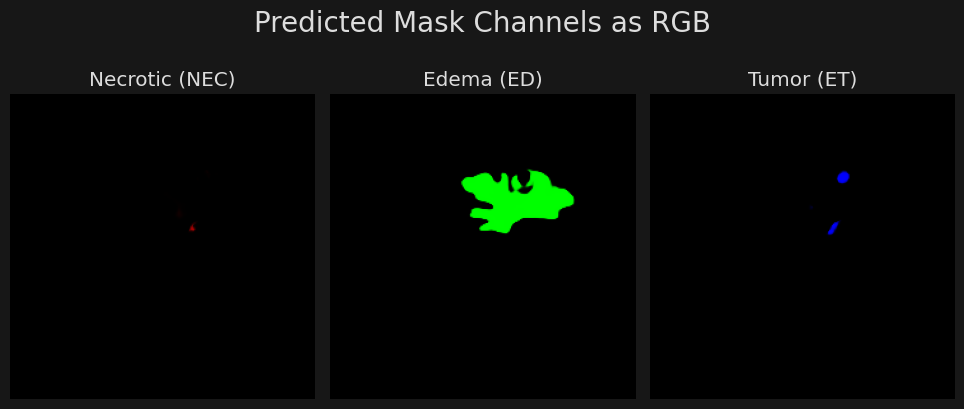

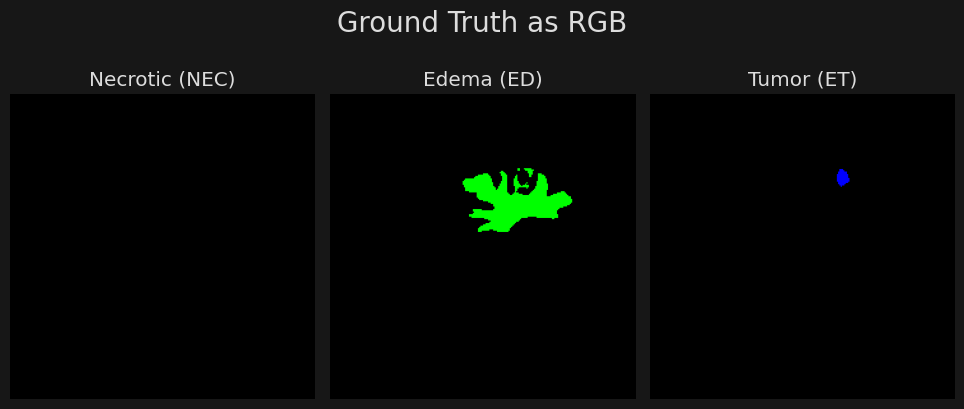

In [52]:
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)

In [53]:
score_model(model, iou_pytorch, DataLoader(val_dataset, batch_size=8, shuffle=False), 3)

IoU for Necrosis: 0.743
IoU for Edema: 0.678
IoU for Tumor: 0.754
Average IoU score: 0.725


## Inference part

In [ ]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    return iou

In [ ]:
def score_model(model, metric, data, num_classes):
    with torch.no_grad():
        model.eval()
        class_scores, class_counts = np.zeros(num_classes), np.zeros(num_classes)
        for X_batch, Y_batch in data:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            logits = model(X_batch)
            Y_pred = torch.sigmoid(logits)

            for class_idx in range(num_classes):
                class_Y_pred = Y_pred[:, class_idx, :, :]
                class_Y_batch = Y_batch[:, class_idx, :, :]
                class_iou = metric(class_Y_pred, class_Y_batch).mean().item()
                class_scores[class_idx] += class_iou
                class_counts[class_idx] += 1

        # Mean scores by classes (and color channels at the same time)
        class_avg_scores = [score / count if count > 0 else 0 for score, count in zip(class_scores, class_counts)]
    print(f'IoU for Necrosis: {round(class_avg_scores[0], 3)}')
    print(f'IoU for Edema: {round(class_avg_scores[1], 3)}')
    print(f'IoU for Tumor: {round(class_avg_scores[2], 3)}')
    print(f'Average IoU score: {round(sum(class_avg_scores)/num_classes, 3)}')

score_model(model, iou_pytorch, DataLoader(val_dataset, batch_size=8, shuffle=False), 3)

In [ ]:
import gc
def all_clean(model=None, train_dataloader=None, val_dataloader=None):
    if model is not None:
        del model
    if train_dataloader is not None:
        del train_dataloader
    if val_dataloader is not None:
        del val_dataloader
    gc.collect()
    torch.cuda.empty_cache()
    print("All clean")

In [56]:
def load_model(model, PATH):
    try: # I've changed bottleneck size through time, soooo
        model.load_state_dict(torch.load(PATH))
    except:
        print("Sheesh")
        n_filters=32
        model.bottleneck = EncoderBlock(8*n_filters, 16*n_filters)
        model.dec_block_4 = DecoderBlock((16+8)*n_filters, 8*n_filters)
        model.load_state_dict(torch.load("PATH"))
    
    model.to(device)

### Basic UNet

In [ ]:
from torch import nn
from torchvision.transforms import CenterCrop

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            activation
        )

    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()

        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, n_filters)
        self.enc_block_2 = EncoderBlock(n_filters, 2*n_filters)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters)

        # Bottleneck
        self.bottleneck  = EncoderBlock(8*n_filters, 8*n_filters)

        # Decoder
        self.dec_block_4 = DecoderBlock((8+8)*n_filters, 8*n_filters)
        self.dec_block_3 = DecoderBlock((8+4)*n_filters, 4*n_filters)
        self.dec_block_2 = DecoderBlock((4+2)*n_filters, 2*n_filters)
        self.dec_block_1 = DecoderBlock((2+1)*n_filters, n_filters)

        # Output projection
        self.output      = nn.Conv2d(1*n_filters, out_channels, kernel_size=(1,1), stride=1, padding=0)


    def forward(self, x):
        e1 = self.enc_block_1(x) # Highest dec block 32
        x  = self.downsample(e1)
        e2 = self.enc_block_2(x) # Second 64
        x  = self.downsample(e2)
        e3 = self.enc_block_3(x) # Third 128
        x  = self.downsample(e3)
        e4 = self.enc_block_4(x) # Above bottleneck 256
        x  = self.downsample(e4)

        # Bottleneck
        x  = self.bottleneck(x) # Should be 512

        # Decoder
        x  = self.upsample(x)
        e4 = CenterCrop(x.shape[2:])(e4)
        # print(e4.shape)
        # print(x.shape)
        d4 = self.dec_block_4(torch.cat([e4, x], dim=1))
        x  = self.upsample(d4)
        e3 = CenterCrop(x.shape[2:])(e3)
        d3 = self.dec_block_3(torch.cat([e3, x], dim=1))
        x  = self.upsample(d3)
        e2 = CenterCrop(x.shape[2:])(e2)
        d2 = self.dec_block_2(torch.cat([e2, x], dim=1))
        x  = self.upsample(d2)
        e1 = CenterCrop(x.shape[2:])(e1)
        d1 = self.dec_block_1(torch.cat([e1, x], dim=1))
        x  = self.output(d1)

        return x

# Function to count number of parameters in a model for comparisons later
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

# Function that saves a model to specified path
def save_model(model, path='model_weights.pth'):
    torch.save(model.state_dict(), path)

#### UNet with Tversky loss 400 batches per epoch (loss bugged)

In [57]:
model = UNet()
PATH = "/kaggle/input/unet20/pytorch/unet/4/UNet_25_epochs.pth"
load_model(model, PATH)

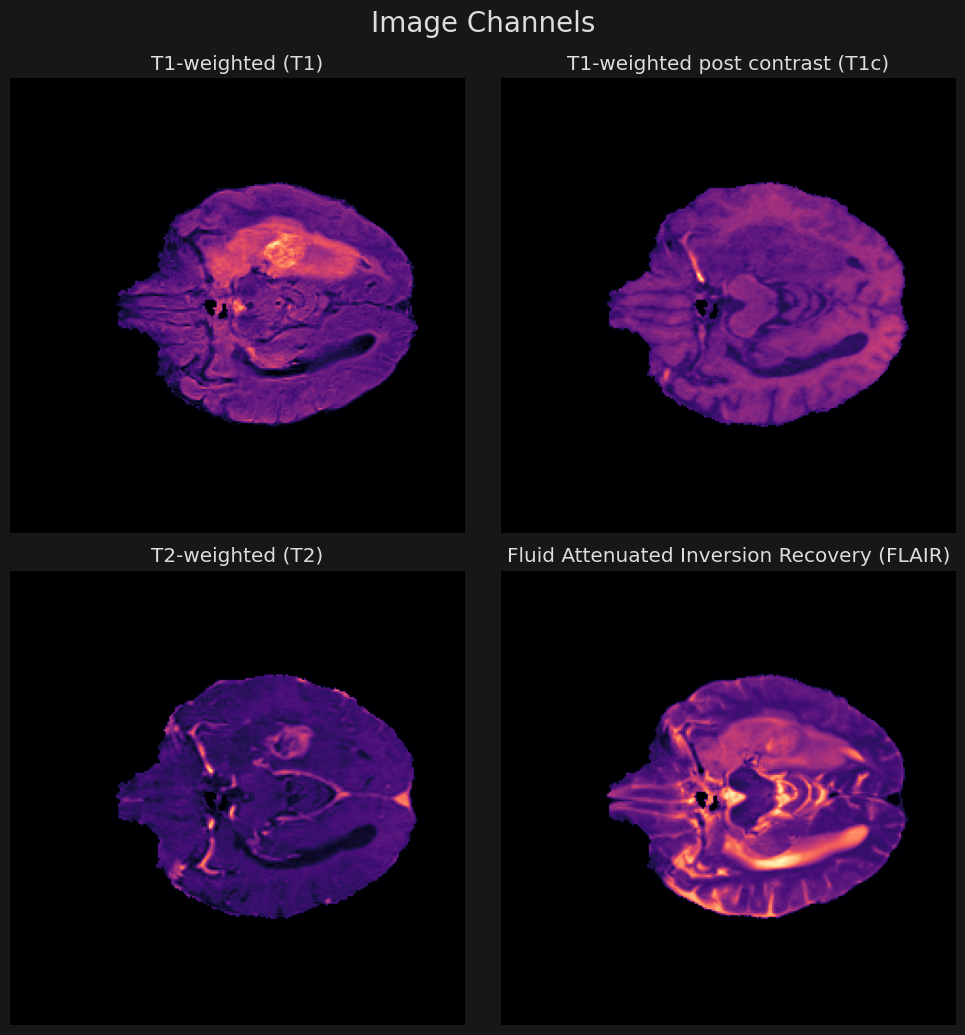

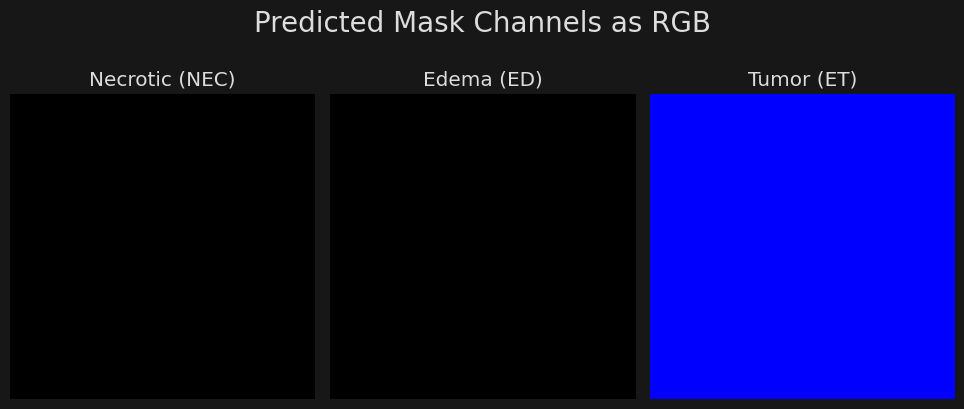

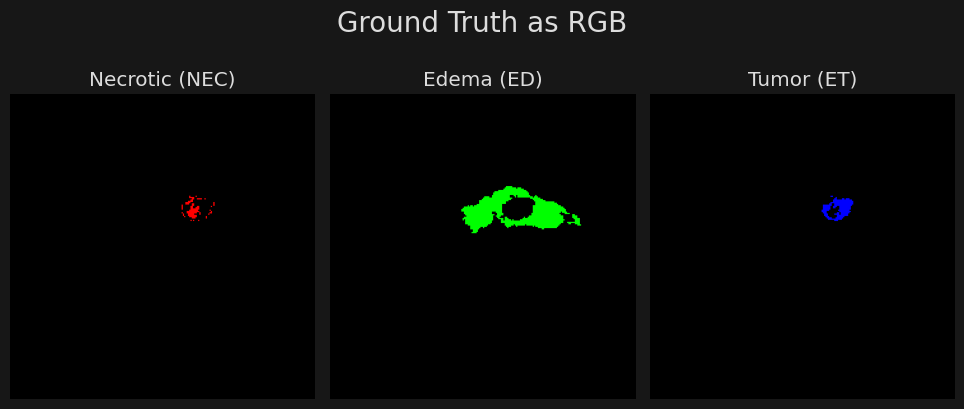

In [53]:
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)

In [58]:
# This model sucks, I know
score_model(model, iou_pytorch, DataLoader(val_dataset, batch_size=8, shuffle=False), 3)

IoU for Necrosis: 0.743
IoU for Edema: 0.591
IoU for Tumor: 0.002
Average IoU score: 0.445


#### UNet with BCEWithLogitsLoss full data

In [59]:
model = UNet()
PATH = "/kaggle/input/unet20/pytorch/unet/4/UNet_2_full_epochs.pth"
load_model(model, PATH)

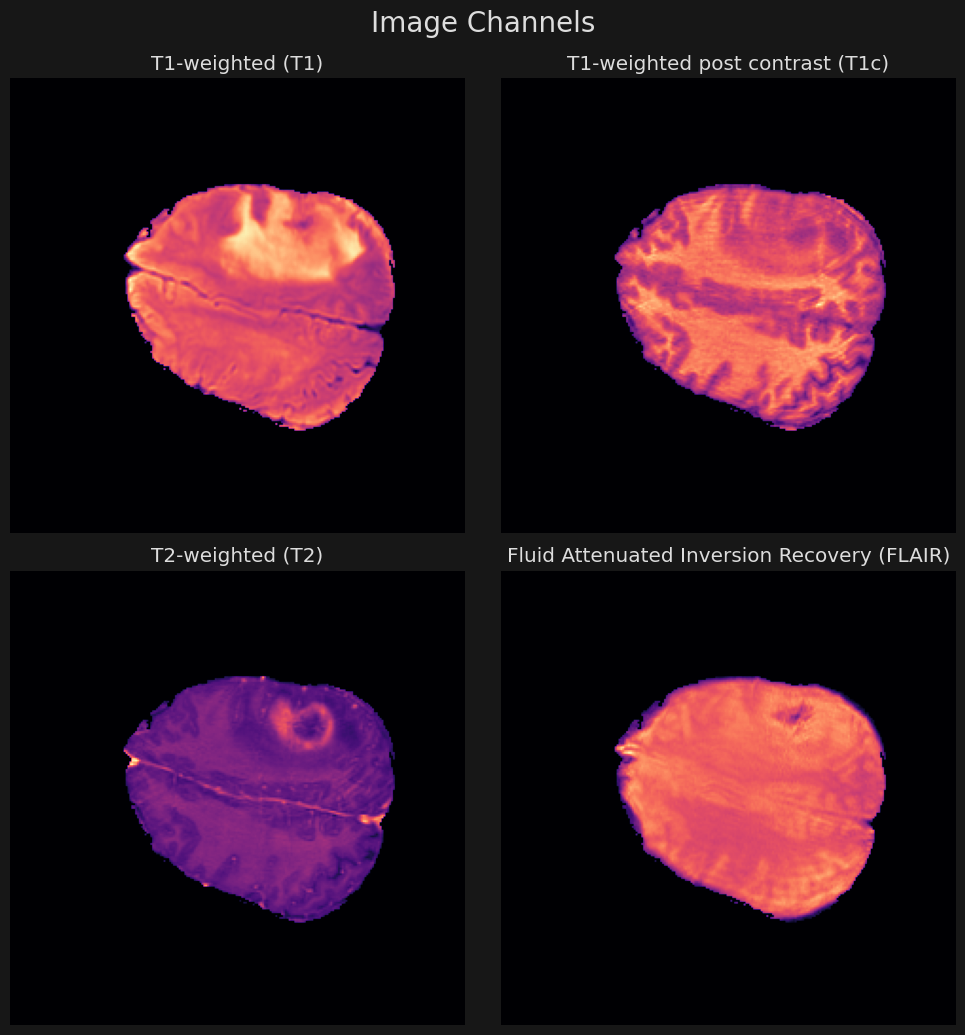

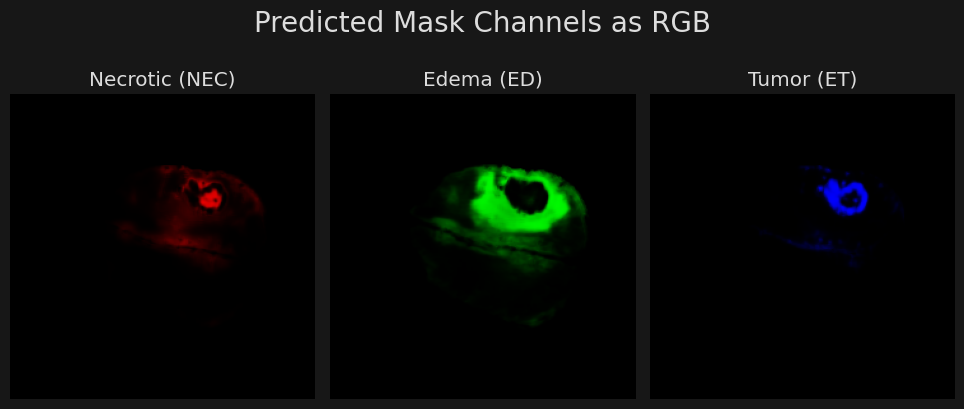

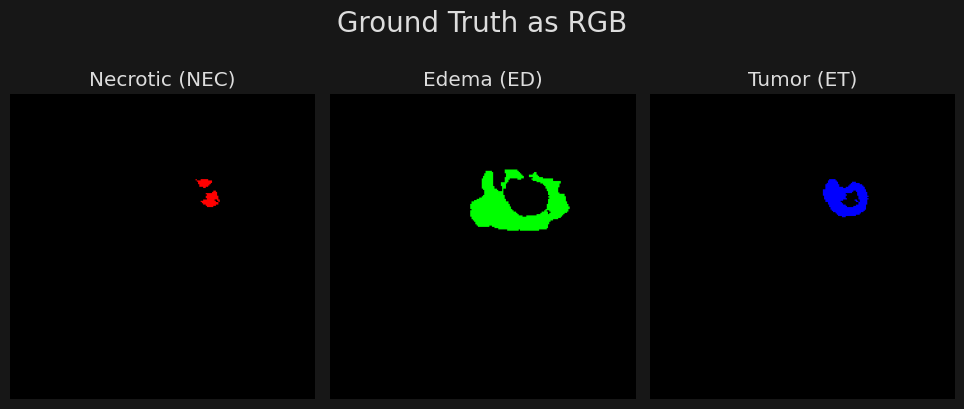

In [61]:
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)

In [62]:
# Much better
score_model(model, iou_pytorch, DataLoader(val_dataset, batch_size=8, shuffle=False), 3)

IoU for Necrosis: 0.743
IoU for Edema: 0.591
IoU for Tumor: 0.754
Average IoU score: 0.696


### UNet2

In [63]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.GELU()):
        super().__init__()
        expansion_ratio = 4   # use it to scale number of channels

        self.encoder_block = nn.Sequential(
            # ConvNeXt style blocks
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels), # convnext-like
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*expansion_ratio, kernel_size=(1,1), stride=1),  # separable 1x1
            activation,
            nn.Conv2d(in_channels=in_channels*expansion_ratio, out_channels=out_channels, kernel_size=(1,1), stride=1),

            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels*expansion_ratio, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(in_channels=out_channels*expansion_ratio, out_channels=out_channels, kernel_size=(1,1), stride=1),
        )
    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.GELU()):
        super().__init__()
        expansion_ratio = 4

        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels), # convnext-like
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*expansion_ratio, kernel_size=(1,1), stride=1),  # separable 1x1
            activation,
            nn.Conv2d(in_channels=in_channels*expansion_ratio, out_channels=out_channels, kernel_size=(1,1), stride=1),

            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels*expansion_ratio, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(in_channels=out_channels*expansion_ratio, out_channels=out_channels, kernel_size=(1,1), stride=1),
        )
    def forward(self, x):
        return self.decoder_block(x)


class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.GELU() # According to ConvNeXt article

        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, n_filters)
        self.enc_block_2 = EncoderBlock(n_filters, 2*n_filters)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(8*n_filters, 8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(4*8*n_filters, 8*n_filters, kernel_size=(1,1), stride=1),

            nn.Conv2d(8*n_filters, 8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(4*8*n_filters, 8*n_filters, kernel_size=(1,1), stride=1),
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(8*n_filters, 4*n_filters)
        self.dec_block_3 = DecoderBlock(4*n_filters, 2*n_filters)
        self.dec_block_2 = DecoderBlock(2*n_filters, n_filters)
        self.dec_block_1 = DecoderBlock(n_filters, n_filters)

        # Output projection
        self.output = nn.Conv2d(n_filters, out_channels, kernel_size=(1,1), stride=1, padding=0)

    def forward(self, x):
        e1 = self.enc_block_1(x)
        x  = self.downsample(e1)
        e2 = self.enc_block_2(x)
        x  = self.downsample(e2)
        e3 = self.enc_block_3(x)
        x  = self.downsample(e3)
        e4 = self.enc_block_4(x)
        x  = self.downsample(e4)

        # Bottleneck
        x  = self.bottleneck(x)

        # Decoder
        x  = self.upsample(x)
        e4 = CenterCrop(x.shape[2:])(e4)
        d4 = self.dec_block_4(torch.add(e4, x))
        x  = self.upsample(d4)
        e3 = CenterCrop(x.shape[2:])(e3)
        # print(e3.shape)
        # print(x.shape)
        d3 = self.dec_block_3(torch.add(e3, x))
        x  = self.upsample(d3)
        e2 = CenterCrop(x.shape[2:])(e2)
        d2 = self.dec_block_2(torch.add(e2, x))
        x  = self.upsample(d2)
        e1 = CenterCrop(x.shape[2:])(e1)
        d1 = self.dec_block_1(torch.add(e1, x))
        x  = self.output(d1)

        return x

In [64]:
model = UNet2()
PATH = "/kaggle/input/unet20/pytorch/unet/4/UNet2_20_epochs.pth"
load_model(model, PATH)

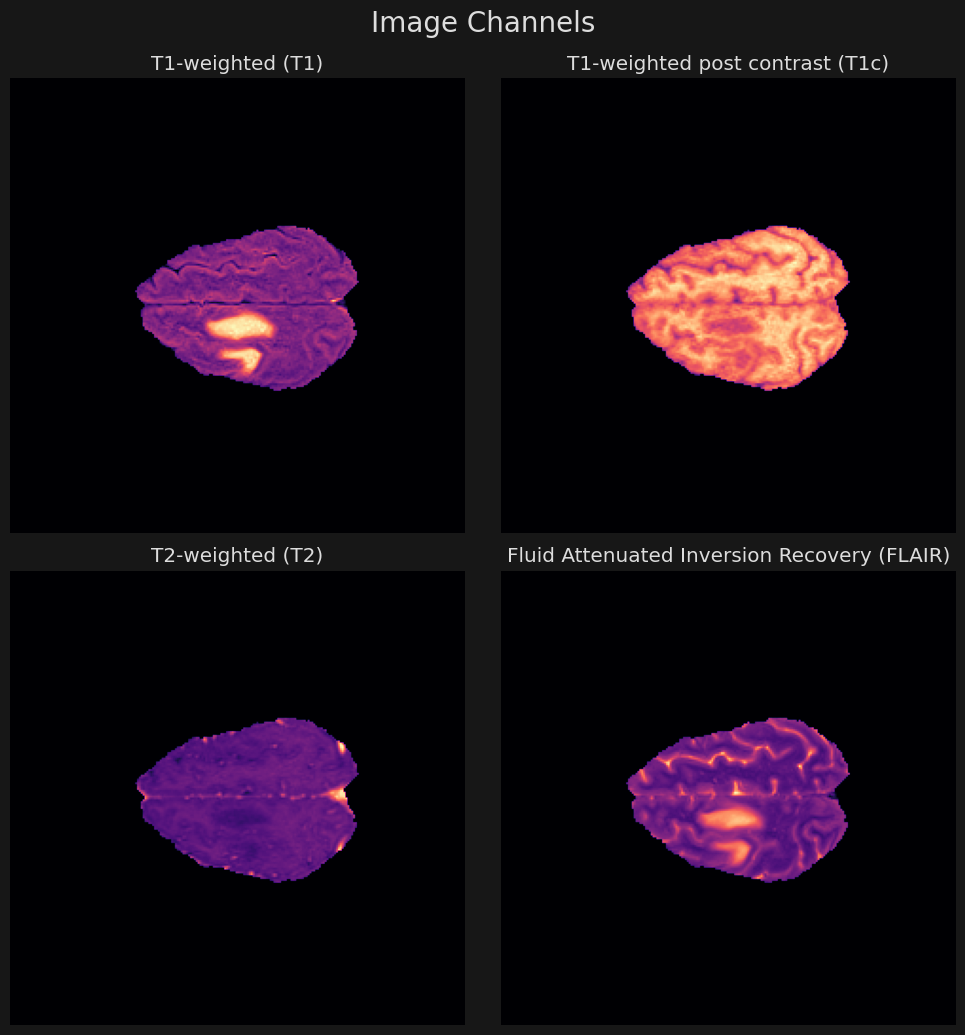

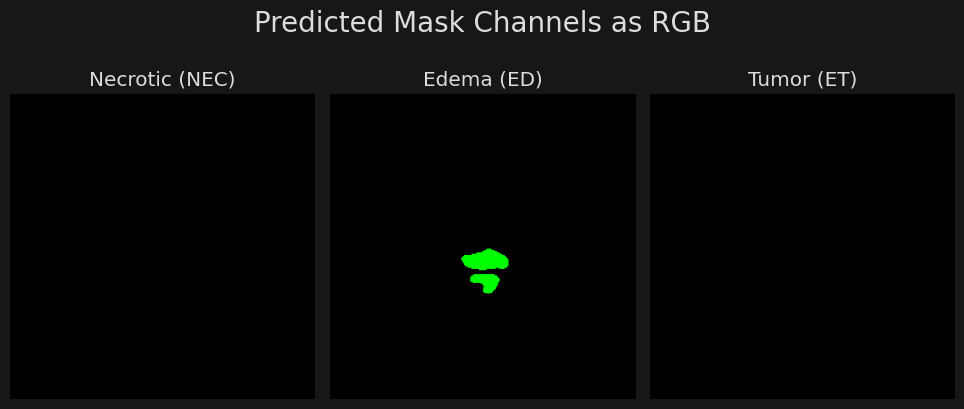

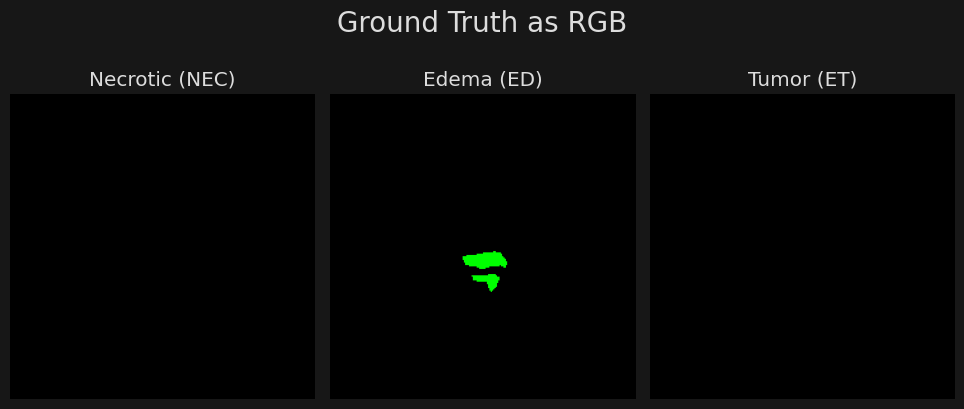

In [66]:
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)

In [67]:
score_model(model, iou_pytorch, DataLoader(val_dataset, batch_size=8, shuffle=False), 3)

IoU for Necrosis: 0.817
IoU for Edema: 0.783
IoU for Tumor: 0.754
Average IoU score: 0.785


#### UNet2 with Tversky loss (400 batches 25 epochs)

In [68]:
model = UNet2()
PATH = "/kaggle/input/unet20/pytorch/unet/4/UNet2_25_epochs.pth"
load_model(model, PATH)

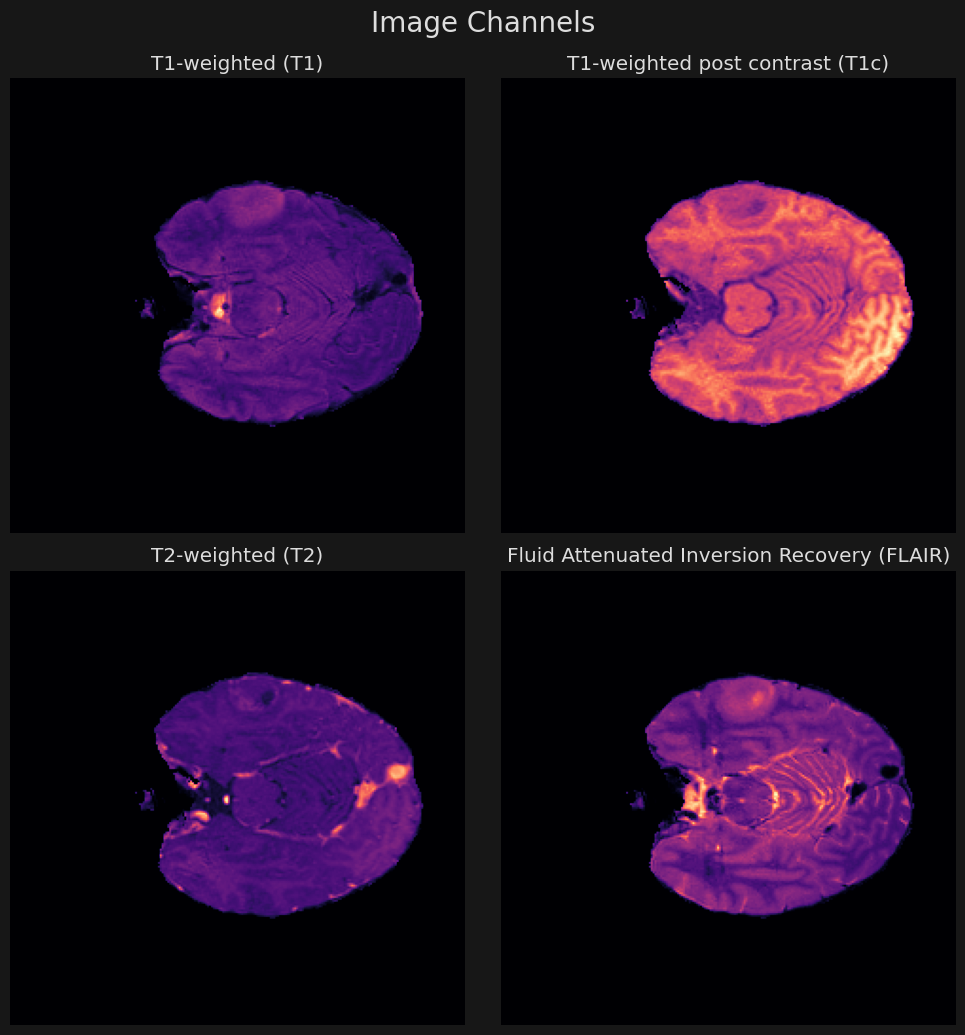

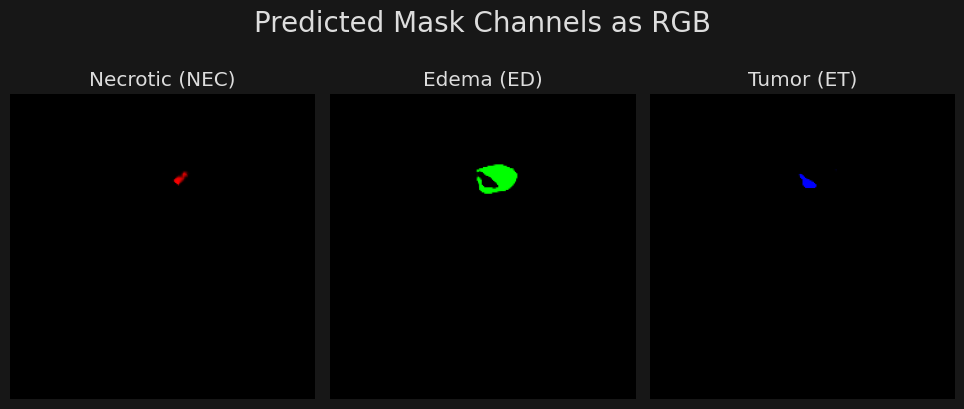

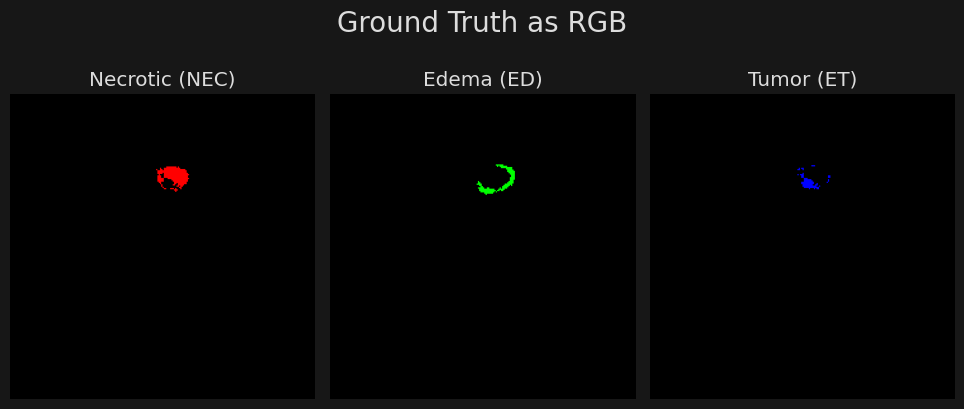

In [75]:
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)

In [76]:
score_model(model, iou_pytorch, DataLoader(val_dataset, batch_size=8, shuffle=False), 3)

IoU for Necrosis: 0.809
IoU for Edema: 0.742
IoU for Tumor: 0.858
Average IoU score: 0.803


#### UNet2 with Tversky loss full data 2 epochs

In [77]:
model = UNet2()
PATH = "/kaggle/input/unet20/pytorch/unet/4/UNet2_2_full_epochs.pth"
load_model(model, PATH)

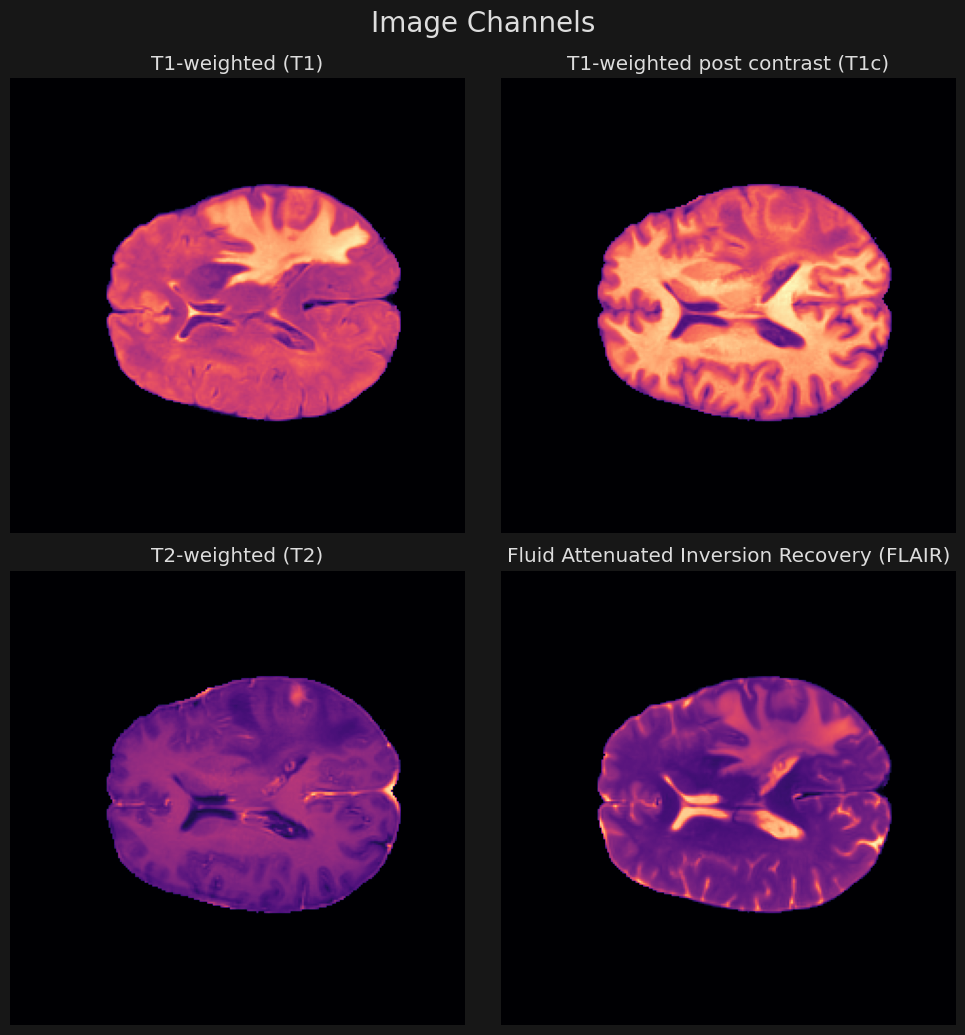

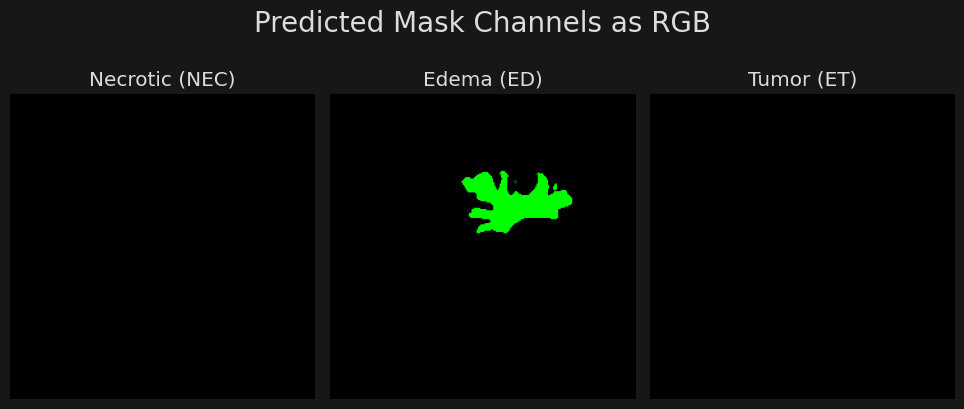

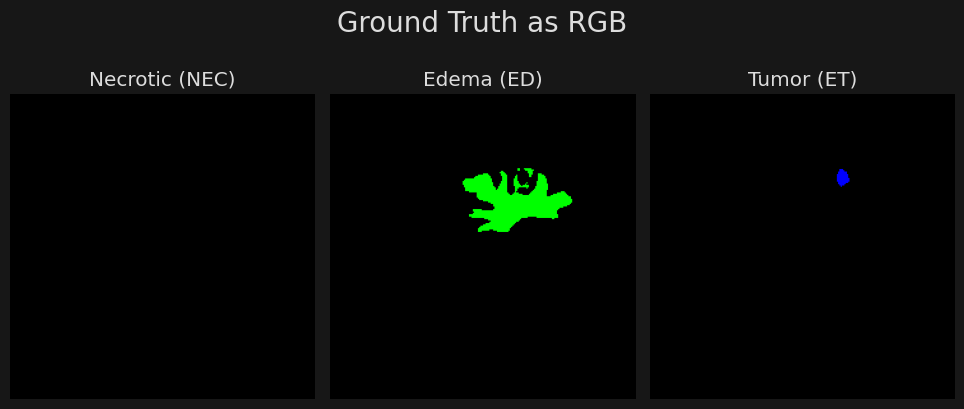

In [79]:
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)

In [80]:
score_model(model, iou_pytorch, DataLoader(val_dataset, batch_size=8, shuffle=False), 3)

IoU for Necrosis: 0.743
IoU for Edema: 0.793
IoU for Tumor: 0.754
Average IoU score: 0.763
